# Jupyterでnapariを起動する
Jupyterノートブックから*Napari*を起動する方法を説明する。
## Hello World
次のセルでは **「Hello World!」** を表示する。

In [1]:
print("Hello World!")

Hello World!


## Jupyterでnapariを起動する


In [2]:
# skimageから3D画像を読み込む
from skimage.data import cells3d

# 画像の各次元のサイズを取得
shape = cells3d().shape
print(f'画像の各次元のサイズ: {shape}')

画像の各次元のサイズ: (60, 2, 256, 256)


In [3]:
# 画像を個々のチャンネルに分離
cell3d_ch0 = cells3d()[:, 0, :, :]
cell3d_ch1 = cells3d()[:, 1, :, :]

# 画像の各次元のサイズを取得
shape = cell3d_ch0.shape

print(f'画像の各次元のサイズ: {shape}')

画像の各次元のサイズ: (60, 256, 256)


In [4]:
# napariをインポート
import napari

# napariのビューアを作成
viewer = napari.Viewer()

# 画像を追加
channel_0_img = viewer.add_image(cell3d_ch0, colormap='magenta', name='channel 0')
channel_1_img= viewer.add_image(cell3d_ch1, colormap='green', name='channel 1')


In [5]:
viewer.layers['channel 0'].scale = [0.29, 0.26, 0.26]
viewer.layers['channel 1'].scale = [0.29, 0.26, 0.26]

In [6]:
# napariビューアを閉じる
viewer.close()

## matplotlib での画像表示

Text(0.5, 1.0, 'cell')

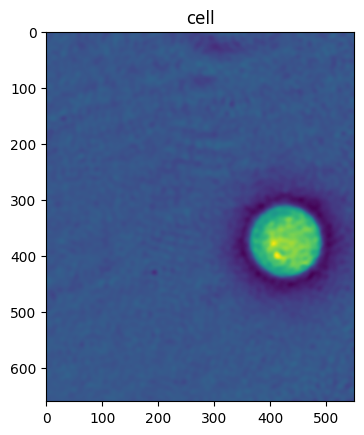

In [7]:
# skimageからcell画像を読み込む
from skimage.data import cell

# matplotlib.pyplotをpltとしてインポート
from matplotlib import pyplot as plt

# cell画像を表示
plt.imshow(cell())

# 画像のタイトルを設定
plt.title('cell')


Text(0.5, 1.0, 'Channel 1')

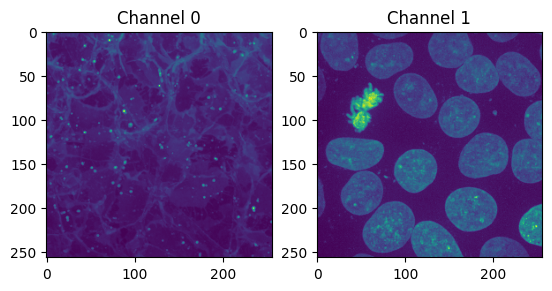

In [8]:
import numpy as np

cell2d_ch0 = np.max(cell3d_ch0, axis=0)
cell2d_ch1 = np.max(cell3d_ch1, axis=0)

# 画像の表示
plt.subplot(1, 2, 1)
plt.imshow(cell2d_ch0)
plt.title('Channel 0')
plt.subplot(1, 2, 2)
plt.imshow(cell2d_ch1)
plt.title('Channel 1')

# Napari Layer(レイヤー)の紹介

## Labels Layer(ラベルレイヤー)
### NapariにLabels Layerを追加する

In [9]:
# 必要なライブラリをインポート
import napari
from skimage.filters import gaussian, threshold_otsu

# napariのビューアを作成
viewer = napari.Viewer()

# 2D画像を追加
viewer.add_image(cell2d_ch0, colormap='magenta', name='channel 0')
viewer.add_image(cell2d_ch1, colormap='green', name='channel 1')

# cell2d_ch1に対してガウスぼかしを適用
cell2d_ch1_blurred = gaussian(cell2d_ch1, sigma=1)
viewer.add_image(cell2d_ch1_blurred, colormap='green', name='channel 1 blurred')

# 大津の閾値処理を適用
thresh = threshold_otsu(cell2d_ch1_blurred)

# cell2d_ch1_blurred画像を核とベックグランドに分けた二値画像に変換する
# 画素値がthresh以下と以上の画素を0 (ベックグランド)、1(核)に転換する
cell2d_ch1_thresholded = cell2d_ch1_blurred > thresh
viewer.add_image(cell2d_ch1_thresholded, colormap='viridis', name='channel 1 thresholded')


<Image layer 'channel 1 thresholded' at 0x28804ab8550>

In [10]:
# 必要なライブラリをインポート
from scipy.ndimage import binary_fill_holes
from skimage.morphology import opening, disk
from skimage.measure import label

# cell2d_ch1_thresholdedに穴埋め操作を適用
cell2d_ch1_filled = binary_fill_holes(cell2d_ch1_thresholded)
viewer.add_image(cell2d_ch1_filled, colormap='viridis', name='channel 1 filled')

# 開操作を適用
cell2d_ch1_opened = opening(cell2d_ch1_filled, disk(5))
viewer.add_image(cell2d_ch1_opened, colormap='viridis', name='channel 1 opened')

# 連結成分分析を適用
cell2d_ch1_labeled = label(cell2d_ch1_opened)
label_layer = viewer.add_labels(cell2d_ch1_labeled, name='channel 1 labeled')


INFO: Current selected label is not being used. You will need to use it first to be able to set the current select label to the next one available


### ラベルを保存する

再標識前のユニークな標識: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 22 25]
再標識後のユニークな標識: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


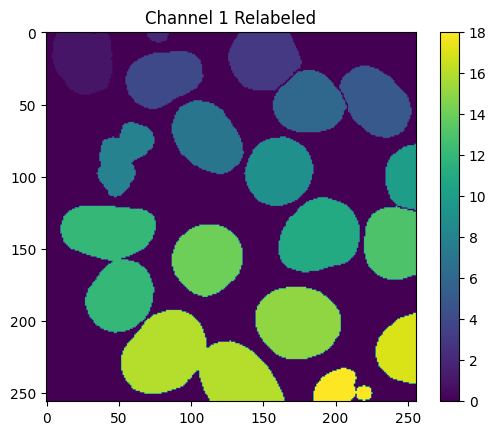

C:\Users\OWNER\AppData\Local\Temp\ipykernel_38376\905543297.py:30: UserWarning: cell2d_ch1_relabel.tif is a low contrast image
  imsave('cell2d_ch1_relabel.tif', cell2d_ch1_relabel)


In [11]:
from skimage.measure import label
from skimage.io import imsave
import matplotlib.pyplot as plt
import numpy as np

# 標識レイヤーから標識データを取得
labeled_image = label_layer.data

# napariビューアを閉じる
viewer.close()

# 再標識前の重複を除いた要素を表示
unique_labels = np.unique(labeled_image)
print(f'再標識前のユニークな標識: {unique_labels}')

# 画像を再標識
cell2d_ch1_relabel = label(labeled_image)

# 再標識後のユニークな要素を表示
unique_labels = np.unique(cell2d_ch1_relabel)
print(f'再標識後のユニークな標識: {unique_labels}')

# 再標識された画像を表示
plt.imshow(cell2d_ch1_relabel)
plt.colorbar()
plt.title('Channel 1 Relabeled')
plt.show()

# 再標識された画像を保存
imsave('cell2d_ch1_relabel.tif', cell2d_ch1_relabel)

### Regionpropsの紹介

In [13]:
import pandas as pd
from skimage.measure import regionprops_table

# 抽出するプロパティを定義
properties = ['label', 'area', 'centroid', 'max_intensity', 'mean_intensity', 'min_intensity']

# プロパティを抽出し、DataFrameに変換
props_df = pd.DataFrame(regionprops_table(cell2d_ch1_relabel, cell2d_ch1, properties=properties))

# DataFrameの最初の数行を表示
props_df.head()

,label,area,centroid-0,centroid-1,max_intensity,mean_intensity,min_intensity
0,1,1544.0,19.823834,25.463083,45903.0,15984.369819,11049.0
1,2,98.0,2.928571,76.908163,21624.0,15452.785714,12946.0
2,3,1682.0,18.956599,150.425684,29258.0,16990.608205,12140.0
3,4,59.0,2.338983,197.644068,23236.0,15983.864407,12993.0
4,5,1597.0,31.976205,80.629931,34617.0,16980.803381,11855.0


Text(0.5, 1.0, 'Cell Area Distribution')

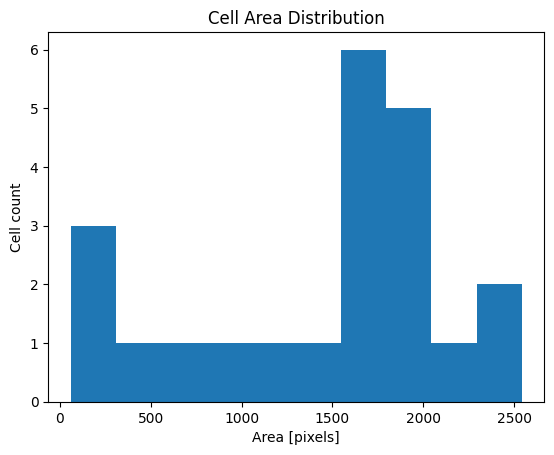

In [14]:
# 面積のヒストグラムを作成する
plt.hist(props_df['area'])
plt.xlabel('Area [pixels]')
plt.ylabel('Cell count')
plt.title('Cell Area Distribution')

## Points Layer (点群レイヤー)

In [15]:
from skimage.io import imread
import napari

# 画像の読み込み
sample_image = imread('sample_images/particle_tracking_sample.tif')

# 画像の形状を表示
print(f'sample_image の画像サイズ: {sample_image.shape}')

# 画像をnapariで表示
viewer = napari.Viewer()
viewer.add_image(sample_image, name='sample_image')

# タイムラプス視覚化のため、時間の次元をスケーリング
viewer.layers['sample_image'].scale = [15, 1, 1]

sample_image の画像サイズ: (18, 555, 554)


In [16]:
import numpy as np
import pandas as pd
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label, regionprops_table

# 閾値処理された標識画像を格納するリスト
labeled_images = []
max_label_last_time_point = 0

# 各タイムポイントで閾値処理とラベリングを適用
for time_point in range(sample_image.shape[0]):
    # ガウスフィルターで画像をスムージング
    smoothed_image = gaussian(sample_image[time_point], sigma=1)
    
    # 大津の閾値処理を適用
    thresholded_image = smoothed_image > threshold_otsu(smoothed_image)

    # 連結成分解析（ラベリング）を実行
    labeled_image = label(thresholded_image)

    # タイムポイント間で標識が一意になるよう調整
    labeled_image_unique = labeled_image + max_label_last_time_point
    labeled_image_unique[labeled_image == 0] = 0
    labeled_images.append(labeled_image_unique)

    # 最大標識を更新
    max_label_last_time_point = np.max(labeled_image_unique)

# リストをNumPy配列に変換
labeled_images = np.array(labeled_images)

# napariで標識付けされた画像を表示
viewer.add_labels(labeled_images, name='labeled_images')
viewer.layers['labeled_images'].scale = [15, 1, 1]

# 標識付けされた領域の幾何中心を取得、データフレームに格納
properties = ['label', 'centroid']
props_df = pd.DataFrame(regionprops_table(labeled_images, properties=properties))

# データフレームの最初の数行を表示
props_df.head()


,label,centroid-0,centroid-1,centroid-2
0,1,0.0,346.431776,234.282243
1,2,1.0,264.918466,199.986338
2,3,2.0,247.146011,168.451975
3,4,3.0,237.254724,153.732558
4,5,4.0,254.974448,118.499655


In [17]:
# データフレームをnapariの表示形式に再整形する：
# 例：points = np.array([[0, 100, 100], [1, 200, 200], [2, 300, 100]])
# まず座標の各次元の数値をそれぞれのリストにする
centroid_0 = np.array(props_df['centroid-0'].to_list())
centroid_1 = np.array(props_df['centroid-1'].to_list())
centroid_2 = np.array(props_df['centroid-2'].to_list())

# 次に、これらのリストを再結合させる
points = np.column_stack((centroid_0, centroid_1, centroid_2))
points


array([[  0.        , 346.4317757 , 234.28224299],
       [  1.        , 264.91846628, 199.98633759],
       [  2.        , 247.14601084, 168.45197521],
       [  3.        , 237.25472384, 153.73255814],
       [  4.        , 254.97444751, 118.4996547 ],
       [  5.        , 201.2266623 , 186.47264985],
       [  6.        , 132.77222222, 204.72962963],
       [  6.        , 154.77910959, 175.15753425],
       [  6.        , 172.24375   , 205.65625   ],
       [  7.        ,  55.04848485, 287.76060606],
       [  7.        , 111.11129296, 196.76759411],
       [  7.        , 160.00233827, 189.41309431],
       [  8.        ,  71.52232519, 313.73462511],
       [  8.        , 127.69103448, 220.55103448],
       [  8.        , 209.59675037, 181.15361891],
       [  9.        ,  50.80448223, 318.8748068 ],
       [  9.        , 113.5074813 , 240.95448878],
       [  9.        , 182.82318653, 265.75194301],
       [ 10.        ,  90.58206987, 283.18061964],
       [ 10.        , 101.55859

In [18]:
# 点群をnapariビューアに点群レイヤーとして追加する
points_layer = viewer.add_points(points, size=10, name='centroids')

# 点群レイヤーのスケールを画像レイヤーと同じように調整する
viewer.layers['centroids'].scale = [15, 1, 1]


In [19]:
# 点のと色（フェイスカラー）をpoints_face_colorリストとして取得する
new_points = points_layer.data
points_face_color = points_layer.face_color

# points_face_colorリスト内のユニークな値を取得する
unique_colors = np.unique(points_face_color, axis=0)

# 色の値を整数のcolor_idに変更する
color_id = np.zeros(len(points_face_color), dtype=int)
for i, color in enumerate(unique_colors):
    color_id[(points_face_color == color).all(axis=1)] = i

# 細胞の軌跡のデータフレームにcolor_idを追加する
new_points_df = pd.DataFrame(new_points)
new_points_df['color_id'] = color_id

# 列の名前Dim-0, 1, 2をわかりやすい名前t,y,xに変える
new_points_df.columns = ['t', 'y', 'x', 'color_id']

# データフレームの最初の数行を表示する
new_points_df.head()


,t,y,x,color_id
0,0.0,346.431776,234.282243,3
1,1.0,264.918466,199.986338,3
2,2.0,247.146011,168.451975,3
3,3.0,237.254724,153.732558,3
4,4.0,254.974448,118.499655,3


## Tracks Layer

In [20]:
# Track Dataframeを編成: new_points_dfのcolor_id列を最初の列に移動し、列名を'track_id'に変更
tracks_df = new_points_df[['color_id', 't', 'y', 'x']]
tracks_df.columns = ['track_id', 't', 'y', 'x']

# Track Dataframeを保存
tracks_df.to_csv('trackdata.csv', index=False)

tracks_df.head()

,track_id,t,y,x
0,3,0.0,346.431776,234.282243
1,3,1.0,264.918466,199.986338
2,3,2.0,247.146011,168.451975
3,3,3.0,237.254724,153.732558
4,3,4.0,254.974448,118.499655


In [21]:
# トラックレイヤーの追加
tracks = viewer.add_tracks(tracks_df, name='tracks')

#トラックレイヤーのスケールを画像レイヤーと同じになるように調整する
viewer.layers['tracks'].scale = [15, 1, 1]

In [22]:
# グラフを定義
graph = {
    0: [3],
    1: [3],
    2: [3],
}
# グラフをNapari add_tracksに追加
connected_tracks = viewer.add_tracks(tracks_df, graph=graph, name='connected_tracks')
viewer.layers['connected_tracks'].scale = [15, 1, 1]

In [23]:
# napariビューアを閉じる
viewer.close()

# トラックデータフレームを保存する
tracks_df.to_csv('tracks.csv', index=False)

## Shape Layer (形レイヤー)

In [1]:
import napari
import numpy as np

# 三角形と長方形の頂点座標を定義
triangle = np.array([[10, 200], [50, 50], [200, 80]])
rectangle = np.array([[40, 40], [40, 80], [80, 80], [80, 40]])

# 三角形と長方形をnapariビューアに形レイヤーとして追加
viewer = napari.Viewer()

# 三角形を追加
triangle_layer = viewer.add_shapes([triangle], shape_type='polygon', edge_color='red', face_color='blue', name='triangle')
# 長方形を追加
rectangle_layer = viewer.add_shapes([rectangle], shape_type='polygon', edge_color='green', face_color='yellow', name='rectangle')


In [2]:
# BloodVessels_small.tif を読み込む
from skimage.io import imread
import napari

blood_vessels = imread('sample_images/blood_vessel_sample.tif')

# 画像を表示する
viewer = napari.Viewer()
blood_vessels_image = viewer.add_image(blood_vessels, name='blood_vessels')

In [19]:
# viewer.layers['blood_vessel_trace']からトレースデータを取得
trace_data = viewer.layers['blood_vessel_trace'].data

# トレースデータをnumpy arrayに変換
# [0]: ここでは、一番最初に描いた血管のデータだけを輸出
trace_data_np_array = np.array(trace_data[0])

# trace_data_np_arrayの各次元のサイズを確認
print(f'trace_data_np_arrayの各次元のサイズは: {trace_data_np_array.shape}')

import pandas as pd
# trace_data_np_arrayからDataFrameを作成
trace_data_df = pd.DataFrame(trace_data_np_array, columns=['z', 'y', 'x'])
trace_data_df.head()

# DataFrameをcsvファイルとして保存
trace_data_df.to_csv('trace_data.csv', index=False)


trace_data_np_arrayの各次元のサイズは: (8, 3)
